# Auto-Encoder

In [1]:
# imports
import torch
import warnings
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
from torchvision.transforms import transforms

warnings.filterwarnings('ignore', category=FutureWarning)

print(f'torch version is : {torch.__version__}')
print(f'numpy version is : {np.__version__}')

torch version is : 2.0.0+cpu
numpy version is : 1.23.5


In [2]:
# Fashion-MNIST data loader
train_dataset = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                                  train=False,
                                  transform=transforms.ToTensor(),
                                  download=True)

100%|██████████| 26421880/26421880 [00:35<00:00, 739118.39it/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 150858.43it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:05<00:00, 808933.69it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 2572653.04it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [3]:
# Batch size, iterations and epochs
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Label 9


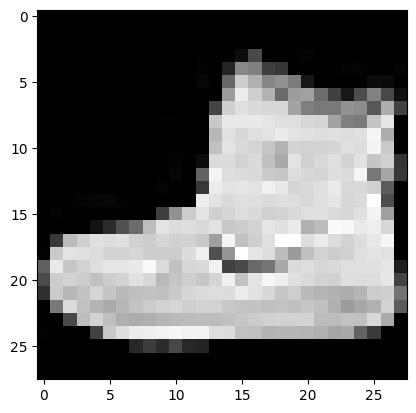

In [4]:
# Sample 0: boot
sample_num = 0
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 0


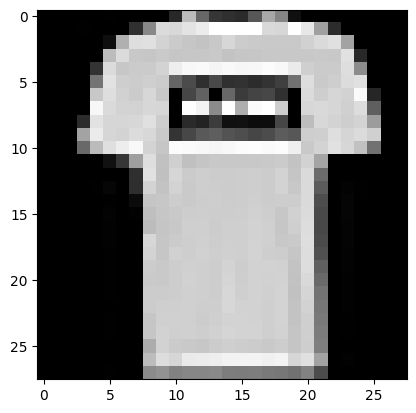

In [5]:
# Sample 1: shirt
sample_num = 1
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

In [6]:
# Model definition
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Decoder: affine function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder: affine function
        out = self.fc1(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.fc2(out)
        # Decoder: non-linear function
        out = torch.sigmoid(out)

        return out

In [7]:
# Dimensions for overcomplete (larger latent representation)
input_dim = 28 * 28
hidden_dim = int(input_dim * 1.5)
output_dim = input_dim

# Instantiate Fully-connected Autoencoder (FC-AE)
# And assign to model object
model = FullyConnectedAutoencoder(input_dim, hidden_dim, output_dim)

In [8]:
# We want to minimize the per pixel reconstruction loss
# So we've to use the mean squared error (MSE) loss
# This is similar to our regression tasks' loss
criterion = nn.MSELoss()

In [9]:
# Using basic Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [ ]:
idx = 0

# Dropout for creating noisy images
# by dropping out pixel with a 50% probability
dropout = nn.Dropout(0.5)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Noisy images
        noisy_images = dropout(torch.ones(images.shape)) * images

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = model(noisy_images)

        # Calculate Loss: MSE Loss based on pixel-to-pixel comparison
        loss = criterion(outputs, images)

        # Getting gradients w.r.t. parameters via backpropagation
        loss.backward()

        # Updating parameters via gradient descent
        optimizer.step()

        idx += 1

        if idx % 500 == 0:
            # Calculate MSE Test Loss
            total_test_loss = 0
            total_samples = 0

            # Iterate through test dataset
            for images, labels in test_loader:
                # Noisy images
                noisy_images = dropout(torch.ones(images.shape)) * images

                # Forward pass only to get logits/output
                outputs = model(noisy_images.view(-1, 28*28))

                # Test loss
                test_loss = criterion(outputs, images.view(-1, 28*28))

                # Total number of labels
                total_samples += labels.size(0)

                # Total test loss
                total_test_loss += test_loss

            mean_test_loss = total_test_loss / total_samples

            # Print Loss
            print(f'Iteration: {idx}. Average Test Loss: {mean_test_loss.item()}.')